In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [80]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

import numpy as np
from textblob import TextBlob
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from spacy.lang.en import English
from spacy.pipeline.textcat import Config, single_label_cnn_config

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from pymongo import MongoClient
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import psycopg2

#vis
import pyLDAvis
import pyLDAvis.gensim

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [5]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
def get_bottom_10_user(data,channel):
    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def get_bottom_10_user_reaction(data,channel):
    data['user_id'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()


def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def plot_common_words(json_file_path, channel_name):
    # Read the JSON file
    with open(json_file_path, 'r', encoding="utf8") as json_file:
        data = json.load(json_file)

    # Convert the data to a DataFrame (adjust as per your JSON structure)
    df = pd.DataFrame(data)

    # Filter messages for the specified channel
    channel_data = df[df['channel'] == channel_name]

    # Combine the text of messages in the channel
    all_text = ' '.join([str(msg.get('text', '')) for msg in channel_data['topic']])

    # Split the text into words
    words = all_text.split()

    # Create a pandas Series for easy word counting
    word_counts = pd.Series(words).value_counts()

    # Plot the top N words
    top_n = 20  # Change this value to adjust the number of words to display
    plt.figure(figsize=(12, 6))
    word_counts.head(top_n).plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} Words in #{channel_name}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

# EDA TASK

In [6]:
def create_dataframe() -> pd.DataFrame:
    DIR = '../anonymized/'
    sl = SlackDataLoader()
    data_frames = [
        sl.slack_parser(DIR + channel['name'] + '/')
        for channel in sl.get_channels()
    ]
    all_data = pd.concat(data_frames, ignore_index=True)
    return all_data

In [7]:
dframe = create_dataframe()
dframe

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"a decent fellow, big ups brother",Gregory Bowman,1664960833.241189,text,1664954598.185699,0,0,0,0,
1,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1664970601.066509,text,0,0,0,0,0,
2,message,when will we kahoot again:smirk:,Jennifer Carrillo,1664970669.636589,text,1664970669.636589,2,2,"U03V1AM5TFA,U03U1FNPEUX",1664970735.145469,
3,message,"soon very soon, you miss it hahahah",Lynn Shepherd,1664970705.135159,text,1664970669.636589,0,0,0,0,
4,message,yess,Jennifer Carrillo,1664970735.145469,text,1664970669.636589,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,how are we going to do the submission today? e...,Monica Newton,1667831518.280939,text,1667831518.280939,1,1,U03TEPYRM2P,1667831802.415459,
17745,message,thank you,Bridget Glover,1667831802.415459,text,1667831518.280939,0,0,0,0,
17746,message,"the document is not uploaded yet, and what is ...",Lisa Dickerson,1667833875.288709,text,1667833875.288709,2,1,U03UP7V9Q57,1667835382.576969,
17747,message,how can i get the trainees that opted-in a giv...,Dennis Parker,1668272023.894179,text,0,0,0,0,0,


#### EDA for reply_count

In [8]:
# Calculate the sum of reply counts for each sender
sender_reply_counts = dframe.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)

# Select the top 10 senders with the highest reply counts
top_10_senders = sender_reply_counts.head(10)

# Create a DataFrame with sender names and their corresponding reply counts
top_10_senders_df = pd.DataFrame({
    'sender_name': top_10_senders.index,
    'reply_count': top_10_senders.values
})

# Display the result
top_10_senders_df

,sender_name,reply_count
0,Lisa Dickerson,620
1,Lynn Shepherd,462
2,Kenneth Williams,367
3,Monica Newton,307
4,Cynthia Davis,306
5,Zachary Clark,302
6,Gregory Bowman,299
7,Kelsey Shields,282
8,Jennifer Carrillo,247
9,James Mann,242


In [9]:
# Select the bottom 10 senders with the lowest reply counts
bottom_10_senders = sender_reply_counts.tail(10)

# Create a DataFrame with sender names and their corresponding reply counts
bottom_10_senders_df = pd.DataFrame({
    'sender_name': bottom_10_senders.index,
    'reply_count': bottom_10_senders.values
})

# Display the result
bottom_10_senders_df

,sender_name,reply_count
0,Jonathan Jenkins,4
1,John Richard,2
2,Austin Franco,0
3,Allen Mccarthy,0
4,Frances Carpenter,0
5,Slackbot,0
6,Luis Smith,0
7,Nicole Medina,0
8,Veronica Richardson,0
9,Mary Allen,0


### SAVE reply_count column to postgers table

In [10]:
# Database connection details
database_host = "localhost"
database_port = 5435
database_name = "slack_db"
database_password = "123"
database_user = "aziza"

# Create an SQLAlchemy engine for database interaction
database_engine = create_engine(f'postgresql://postgres:{database_password}@{database_host}:{database_port}/{database_name}')
sender_reply_counts.to_sql('reply_count', database_engine, if_exists='replace')
database_engine.dispose()

#### For EDA for message_count

In [11]:
# Calculate the message count for each sender
sender_message_counts = dframe['sender_name'].value_counts()

# Select the top 10 senders with the highest message counts
top_10_senders = sender_message_counts.head(10)

# Create a DataFrame with sender names and their corresponding message counts
top_10_senders_df = pd.DataFrame({
    'sender_name': top_10_senders.index,
    'message_count': top_10_senders.values
})

# Display the result
top_10_senders_df

,sender_name,message_count
0,Lynn Shepherd,1288
1,Kelsey Shields,1150
2,Gregory Bowman,1075
3,Zachary Clark,991
4,Monica Newton,843
5,Lisa Dickerson,831
6,Ariel Lopez,754
7,James Mann,641
8,Tammy Foster,574
9,Jennifer Carrillo,519


In [12]:
# Select the bottom 10 senders with the lowest message counts
bottom_10_senders = sender_message_counts.tail(10)

# Create a DataFrame with sender names and their corresponding message counts
bottom_10_senders_df = pd.DataFrame({
    'sender_name': bottom_10_senders.index,
    'message_count': bottom_10_senders.values
})

# Display the result
bottom_10_senders_df

,sender_name,message_count
0,John Richard,10
1,Luis Smith,8
2,Jonathan Jenkins,7
3,Frances Carpenter,5
4,Slackbot,3
5,Mary Allen,1
6,Austin Franco,1
7,Nicole Medina,1
8,Veronica Richardson,1
9,Allen Mccarthy,1


### Save the message_count column to postgers table

In [13]:
# Database connection details
database_host = "localhost"
database_port = 5435
database_name = "slack_db"
database_password = "123"
database_user = "aziza"

# Create an SQLAlchemy engine for database interaction
database_engine = create_engine(f'postgresql://postgres:{database_password}@{database_host}:{database_port}/{database_name}')

sender_message_counts.to_sql('message_count', database_engine, if_exists='replace')
database_engine.dispose()

#### EDA for reaction

In [14]:
DIR = '../anonymized/'
sl = SlackDataLoader()

def get_all_reaction():
    all_reactions = []

    # Provide a list of channel names
    channel_list = sl.get_channels()
    channel_names = [channel_list[i]['name'] for i in range(len(channel_list))]

    # Iterate through each channel name and parse reaction data
    for channel_name in channel_names:
        data = sl.parse_slack_reaction(channel_name + "/")
        all_reactions.append(data)

    reaction_dframe = pd.concat(all_reactions, ignore_index=True)
    return reaction_dframe

In [18]:
sl = SlackDataLoader()
def generate_user_mapping(sl):
    users_map = sl.get_user_map()[0]
    user_names_list = pd.DataFrame({
        'user_id': list(users_map.keys()),
        'user_name': list(users_map.values())
    })
    return user_names_list

def return_all_user_reaction():
    reaction_dframe = get_all_reaction()
    user_names_list = generate_user_mapping(sl)
    user_reaction_counts = reaction_dframe['user_id'].value_counts()
    

    # Merge user_reaction_counts with user_names_list
    all_users_with_reaction_count = (
        pd.DataFrame({'user': user_reaction_counts.index, 'reaction_count': user_reaction_counts.values})
        .merge(user_names_list, left_on='user', right_on='user_id', how='left')
        .rename(columns={'user_name': 'user'})
        .loc[:, ['user', 'reaction_count']]
    )
    return all_users_with_reaction_count

In [19]:
def get_top_users_by_reaction(all_users_with_reaction_count, N=10):
    top_users_with_reaction_count = all_users_with_reaction_count.head(N)
    return top_users_with_reaction_count

In [20]:
top_10_users_with_reaction_count = get_top_users_by_reaction(return_all_user_reaction())
pd.DataFrame(top_10_users_with_reaction_count)

,user,user,reaction_count
0,U03V1AM5TFA,Lynn,427
1,U03UG32J3PC,Zachary,335
2,U03UUR571A5,Kelsey,332
3,U03UVHCV6KB,Gregory,248
4,U03V6HMRPGQ,Lisa,243
5,U03UJGP0C68,Tammy,236
6,U03UD68RQH3,James,223
7,U03UG4Q7V42,Ariel,222
8,U03U1FNPEUX,Jennifer,196
9,U03UJKJGRAQ,Kenneth,190


In [21]:
def get_bottom_users_by_reaction(all_users_with_reaction_count, N=10):
    bottom_users_with_reaction_count = all_users_with_reaction_count.tail(N)
    return bottom_users_with_reaction_count

In [22]:
bottom_10_users_with_reaction_count = get_bottom_users_by_reaction(return_all_user_reaction())
pd.DataFrame(bottom_10_users_with_reaction_count)

,user,user,reaction_count
47,U03UUMR26Q1,Trevor,15
48,U03U1FQKEMV,Kevin,11
49,U03UP7V9Q57,Gabrielle,11
50,U03UKGSDGSG,John,7
51,U03UG569P7U,Karen,7
52,U03UDBUL7CL,Luis,5
53,U03UYNR4TS4,Frances,4
54,U03UJGFG2HJ,Erin,4
55,U03UG03HQ2F,Mary,1
56,U03UD63A8PP,Jonathan,1


#### SAVE the reaction_count column to postges table

In [23]:
database_host = "localhost"
database_port = 5435
database_name = "slack_db"
database_password = "123"
database_user = "aziza"

database_engine = create_engine(f'postgresql://postgres:{database_password}@{database_host}:{database_port}/{database_name}')
all_users_with_reaction_count = return_all_user_reaction()
# Table name
table_name = 'reaction_count'

# Write the DataFrame to a new table
all_users_with_reaction_count.to_sql(table_name, database_engine, if_exists='replace')

# Dispose of the engine
database_engine.dispose()

/Users/azizamed/anaconda3/lib/python3.11/site-packages/pandas/io/sql.py:1225: SADeprecationWarning: A column with name 'user' is already present in table 'reaction_count'. Please use method :meth:`_schema.Table.append_column` with the parameter ``replace_existing=True`` to replace an existing column.
  return Table(self.name, meta, *columns, schema=schema)


### EDA for message 

In [24]:
def message_with_replies(data: pd.DataFrame):
    df = data.sort_values(by='reply_count', ascending=False)
    return df

In [25]:
#message with top replies
messages = message_with_replies(dframe)
messages.head(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
7208,message,<@u03v1am5tfa> how many crushes you have?,Kenneth Williams,1668169350.223689,user,1668169350.223689,75,8,"U03V1AM5TFA,U03UUS0MZCZ,U03UG32J3PC,U03UVHCV6K...",1668173595.550369,
975,message,first impression: people think i am older than...,Kevin Macdonald,1663072090.617319,text,1663072090.617319,63,8,"U03UUR571A5,U03UG32J3PC,U03UFV7TUTV,U03V785NLS...",1663077515.282329,
15078,message,1. how do i find my jupyter notebook file in m...,James Mann,1664916746.043439,rich_text_section,1664916746.043439,61,5,"U03UUR571A5,U03UVHCV6KB,U03U9EJR362,U03UD68RQH...",1664920378.724399,
1546,message,how many here follow football so much? i think...,Kenneth Williams,1666700374.650289,text,1666700374.650289,57,10,"U03V5Q9N516,U03V785NLSU,U03UG32J3PC,U03UJN29Y4...",1666709362.373899,
10053,message,ethiopian new year loading ....,Bryan Clark,1662400744.293029,text,1662400744.293029,54,3,"U03UG32J3PC,U03UUR571A5,U03UFV7TUTV",1662406508.168569,
11662,message,hello\n1. <@u03uvhcv6kb>\n2. <@u03ug5vfn03>\n3...,Lynn Shepherd,1667286619.471889,text,1667286619.471889,45,7,"U03UG32J3PC,U03UG0SFHGT,U03UG5VFN03,U03V1AM5TF...",1667308401.183059,
16495,message,<@u03uur571a5> solutions to funding account an...,Jason Burnett,1666858629.076399,user,1666858629.076399,44,4,"U03UUR571A5,U03UJGP0C68,U03U1FNPEUX,U03UKL27B0R",1666944753.417749,
10141,message,we had a plan to meet today 2:00 eat at friend...,Zachary Clark,1667700160.574059,text,1667700160.574059,36,4,"U03UG32J3PC,U03UUR571A5,U03UD68RQH3,U03UG0YHAUT",1667713572.552719,
11757,message,*<!here> reminder*:timer_clock:\n\n*please not...,Lynn Shepherd,1665137100.215739,broadcast,1665137100.215739,33,3,"U03UH397319,U03TEPYRM2P,U03V1AM5TFA",1665142057.729989,
6843,message,"the debate was great. we <@u03u1j51vfz>, <@u03...",Kenneth Williams,1665057691.571429,text,1665057691.571429,31,12,"U03UUR571A5,U03U1J51VFZ,U03UD68RQH3,U03UJN29Y4...",1665059196.765399,


In [26]:
#messages with low replies
messages.tail(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
6286,message,i knew Lynn would gloat on my absence.:rolling...,Ariel Lopez,1667223458.795429,text,1667219058.497169,0,0,0,0,
6287,message,"<@u03ujkjgraq> what exactly will you miss, don...",Lynn Shepherd,1667224541.153779,user,1667218895.649919,0,0,0,0,
6288,message,".. i will miss everything, particularly the fu...",Kenneth Williams,1667224846.565619,text,1667218895.649919,0,0,0,0,
6289,message,physically yes but mentally is the reverse one...,Steven Haas,1667226264.158849,text,0,0,0,0,0,
6290,message,aaaa <@u03v1am5tfa> sorry man. but for sure i'...,Pamela Garcia,1667227856.149669,text,1667219340.307769,0,0,0,0,
6292,message,adult or kid's toy?,Cynthia Davis,1667279705.726879,text,1667250876.632019,0,0,0,0,
6293,message,everyone’s,Jennifer Carrillo,1667280893.982019,text,1667250876.632019,0,0,0,0,
6294,message,"hmmm, that i dont know",Cynthia Davis,1667281453.783909,text,1667250876.632019,0,0,0,0,
6295,message,<https://www.genardmethod.com/blog/bid/80384/h...,Gregory Bowman,1667283861.061099,link,0,0,0,0,0,
17748,message,<https://developer.algorand.org/solutions/mint...,Dennis Parker,1668359175.400459,link,0,0,0,0,0,


In [27]:
def messages_with_reactions(data: pd.DataFrame):
    return data.sort_values(by='reaction_count', ascending=False)

In [28]:
dframe_reaction = get_all_reaction()
messages = messages_with_reactions(dframe_reaction)

In [29]:
messages.head(10)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
4695,white_check_mark,17,"U03UG5VFN03,U03UJGP0C68,U03V785NLSU,U03UG0YHAU...","good morning winners, welcome to week 9 of wee...",U03TEPYRM2P,all-week9/
2138,joy,16,"U03UUR571A5,U03V785NLSU,U03UD68RQH3,U03UD4FEDH...",my reactions when am not finished the task bef...,U03UG0SFHGT,all-community-building/
249,raised_hands,16,"U03UD68RQH3,U03U9EJR362,U03UFV7TUTV,U03U1FNPEU...",,U03U1GHT39V,all-community-building/
4085,raised_hands,16,"U03U1GHT39V,U03UJN29Y4C,U03UG1RTXAP,U03UG4Q7V4...",little known fact - all Joanne academy technic...,U03U93GNNVB,all-broadcast/
1322,rolling_on_the_floor_laughing,15,"U03UG32J3PC,U03U9EJR362,U03U1HAG9TR,U03UJGP0C6...",*guys <!here>.... make sure to come back from ...,U03V1AM5TFA,all-community-building/
4468,raised_hands,15,"U03UG32J3PC,U03V61VGQG0,U03UG0YHAUT,U03UJGRN5E...","welcome to week6 everyone. by friday, we’ll be...",U03TEPYRM2P,all-week6/
1444,joy,15,"U03V6HMRPGQ,U03U9EJR362,U03UFV7HFNF,U03UVHCV6K...",*here are some other stories from people that ...,U03V1AM5TFA,all-community-building/
1404,rolling_on_the_floor_laughing,14,"U03UJGP0C68,U03UG4Q7V42,U03UFV7HFNF,U03UG1Z21J...","1- let me open my vpn, where do you want me to...",U03V6HMRPGQ,all-community-building/
3245,raised_hands,14,"U03UJGP0C68,U03UG32J3PC,U03UG0SFHGT,U03UG1Z21J...",<!channel>\nthere will be no careers exercise ...,U03TT5KEYCF,all-career-exercises/
1640,joy,13,"U03UJKJGRAQ,U03UD68RQH3,U03U1HAG9TR,U03UG4Q7V4...",3 things i dont want him to know:\n\n1. that i...,U03UG1Z21JP,all-community-building/


In [30]:
#message with lowest reactions
messages.tail(10)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
2182,rolling_on_the_floor_laughing,1,U03UJGP0C68,<@u03uur571a5> :rolling_on_the_floor_laughing:...,U03UG4Q7V42,all-community-building/
2183,rolling_on_the_floor_laughing,1,U03UG32J3PC,do you remember the one who completes this ser...,U03UG0YHAUT,all-community-building/
2186,joy,1,U03UG1Z21JP,"yeah <@u03uvhcv6kb>, one day when i was coming...",U03UG0YHAUT,all-community-building/
2188,raised_hands,1,U03UG0YHAUT,the tings i would give to go back !!,U03UVHCV6KB,all-community-building/
2190,raised_hands::skin-tone-3,1,U03U9EJR362,lets use week 8 groups,U03V1AM5TFA,all-community-building/
2193,raised_hands::skin-tone-3,1,U03U9EJR362,on behalf of group 1:\n1. communication \n2. c...,U03UJKJGRAQ,all-community-building/
2194,raised_hands::skin-tone-4,1,U03UG4Q7V42,on behalf of group 1:\n1. communication \n2. c...,U03UJKJGRAQ,all-community-building/
2196,white_check_mark,1,U03U1FNPEUX,group 4:\nJoanne life lessons in Joanne weeks\...,U03UG0YHAUT,all-community-building/
2197,raised_hands::skin-tone-4,1,U03UG4Q7V42,group 4:\nJoanne life lessons in Joanne weeks\...,U03UG0YHAUT,all-community-building/
5016,raised_hands,1,U03UVHCV6KB,<@u03ul5lstg9> has joined the channel,U03UL5LSTG9,data-engineering/


In [31]:
user_message_counts = dframe['sender_name'].value_counts()

In [32]:
print(user_message_counts)

sender_name
Lynn Shepherd          1288
Kelsey Shields         1150
Gregory Bowman         1075
Zachary Clark           991
Monica Newton           843
                       ... 
Mary Allen                1
Austin Franco             1
Nicole Medina             1
Veronica Richardson       1
Allen Mccarthy            1
Name: count, Length: 62, dtype: int64


/Users/azizamed/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


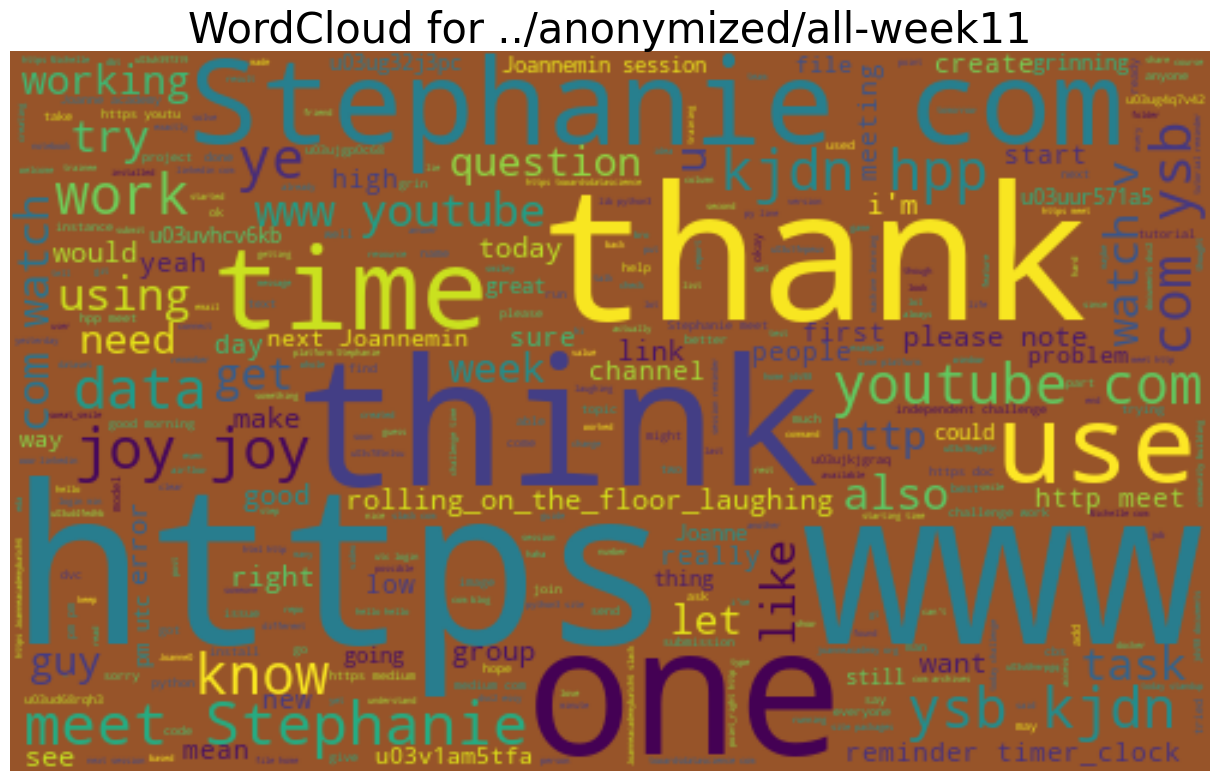

In [33]:
draw_wordcloud(dframe['msg_content'],'../anonymized/all-week11')

In [34]:
# Convert DataFrame to JSON string
json_data = dframe.to_json(orient='records')

# Write JSON data to a file
with open('slack_data.json', 'w') as file:
    file.write(json_data)

In [35]:
def is_mongo_connected():
    try:
        # Get MongoDB connection details from environment variables
        mongo_username = os.environ.get("MONGO_INITDB_ROOT_USERNAME")
        mongo_password = os.environ.get("MONGO_INITDB_ROOT_PASSWORD")
        mongo_host = "localhost"
        mongo_port = 27017

        # Create MongoDB client with authentication
        client = MongoClient(mongo_host,mongo_port)

        # Check if the connection is successful
        client.server_info()

        # If the connection is successful, return True
        return True
    except Exception as e:
        # If there's an error, print it (optional) and return False
        print(f"Error: {e}")
        return False
    finally:
        # Close the MongoDB client in any case
        if client:
            client.close()


In [36]:
# Get MongoDB connection details from environment variables
mongo_username = os.environ.get("MONGO_INITDB_ROOT_USERNAME")
mongo_password = os.environ.get("MONGO_INITDB_ROOT_PASSWORD")
mongo_host = "localhost"
mongo_port = 27017

        # Create MongoDB client with authentication
client = MongoClient(mongo_host,mongo_port)
print(client)

# Check if we can connect to MongoDB
if is_mongo_connected():
    print("Connected to MongoDB")
else:
    print("Failed to connect to MongoDB")

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)
Connected to MongoDB


In [37]:
mongo_host = "localhost"
mongo_port = 27017

# Create MongoDB client with authentication
client = MongoClient(mongo_host,mongo_port)

# Create a database
db = client['slack_mongodb']

# Create a collection
collection = db['all_slack_data']

# Load data from JSON file and insert into the collection
with open('slack_data.json') as file:
    data = json.load(file)
    collection.insert_many(data)

# Close the MongoDB client
client.close()

In [38]:
# MongoDB connection details
mongo_host = "localhost"
mongo_port = 27017

# Create MongoDB client with authentication
client = MongoClient(mongo_host, mongo_port)

# Access the database and collection
db = client['slack_mongodb']
collection = db['all_slack_data']

# Query all documents in the collection
cursor = collection.find()

# Print each document in the collection
for document in cursor:
    print(document)

# Close the MongoDB client
client.close()

{'_id': ObjectId('656b72930697f2d37462774b'), 'msg_type': 'message', 'msg_content': 'a decent fellow, big ups brother', 'sender_name': 'Gregory Bowman', 'msg_sent_time': '1664960833.241189', 'msg_dist_type': 'text', 'time_thread_start': '1664954598.185699', 'reply_count': 0, 'reply_users_count': 0, 'reply_users': 0, 'tm_thread_end': 0, 'channel': ''}
{'_id': ObjectId('656b72930697f2d37462774c'), 'msg_type': 'message', 'msg_content': '*community building session reminder!*:timer_clock: *<!here>*\n*please note that cbs is on in the next Joannemin*\n• *session: laugh and learn*\n• *time*: from 12:00 pm - 12:30 pm utc\n*platform:* slack', 'sender_name': 'Lynn Shepherd', 'msg_sent_time': '1664970601.066509', 'msg_dist_type': 'text', 'time_thread_start': 0, 'reply_count': 0, 'reply_users_count': 0, 'reply_users': 0, 'tm_thread_end': 0, 'channel': ''}
{'_id': ObjectId('656b72930697f2d37462774d'), 'msg_type': 'message', 'msg_content': 'when will we kahoot again:smirk:', 'sender_name': 'Jennife

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




{'_id': ObjectId('656ce0e95dfaeb9dad93d310'), 'msg_type': 'message', 'msg_content': 'okay', 'sender_name': 'Heidi Martin', 'msg_sent_time': '1665515573.367699', 'msg_dist_type': 'text', 'time_thread_start': 0, 'reply_count': 0, 'reply_users_count': 0, 'reply_users': 0, 'tm_thread_end': 0, 'channel': ''}
{'_id': ObjectId('656ce0e95dfaeb9dad93d311'), 'msg_type': 'message', 'msg_content': 'am i the only one who is facing this error? may be from configuration on my side:thinking_face:', 'sender_name': 'Heidi Martin', 'msg_sent_time': '1665518739.122139', 'msg_dist_type': 'text', 'time_thread_start': '1665515415.543639', 'reply_count': 0, 'reply_users_count': 0, 'reply_users': 0, 'tm_thread_end': 0, 'channel': ''}
{'_id': ObjectId('656ce0e95dfaeb9dad93d312'), 'msg_type': 'message', 'msg_content': 'upgrade/downgrade your matplotlib to\n```matplotlib==3.2.2```\n', 'sender_name': 'Kelsey Shields', 'msg_sent_time': '1665518845.466379', 'msg_dist_type': 'text', 'time_thread_start': '1665518630.

In [39]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [40]:
data = dframe['msg_content'].values.tolist()

data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"@U\w+", "", sent) for sent in data]

In [47]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

print(data_words[1][0:50])

['community', 'building', 'session', 'reminder', 'timer_clock', 'here', 'please', 'note', 'that', 'cbs', 'is', 'on', 'in', 'the', 'next', 'joannemin', 'session', 'laugh', 'and', 'learn', 'time', 'from', 'pm', 'pm', 'utc', 'platform', 'slack']


In [53]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[1][0:50]]])

['community_building_session', 'reminder_timer_clock_here', 'please_note', 'that', 'cbs', 'is', 'on', 'in', 'the', 'next_joannemin_session', 'laugh', 'and', 'learn', 'time', 'from', 'pm_pm_utc', 'platform', 'slack']


In [54]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [55]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[1][0:50])

['community_builde', 'session', 'session', 'laugh', 'learn', 'time', 'platform', 'slack']


In [56]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1)], [], [(12, 1), (13, 1), (14, 2)], [(15, 1)], [(16, 1), (17, 1)], [(18, 1)], [], [], [(19, 1)], [], [], [], [], [], [(19, 1)], [], [(20, 1)], [(19, 1)], [], [], [(6, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)], [(19, 1)], [(29, 1)], [(30, 1)], [(6, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(28, 1), (30, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(25, 1)], [], [(41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(41, 1), (47, 1)], [(6, 1), (36, 1), (46, 1), (48, 1), (49, 1), (50, 1)], [(48, 1), (51, 1)], [(52, 1), (53, 1)], [(54, 1)], [(29, 1), (36, 1), (55, 1), (56, 1)], [(6, 1), (28, 1), (39, 1), (40, 1), (57, 1), (58, 1)], [(14, 1)], [(30, 1)], [(36, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(63, 1), (64, 1)], [(0, 1), (22, 1), (25, 1), (26, 1), (28, 1), (37, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(52, 1), (59, 1), (60, 1)], [(36

In [57]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [58]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.293*"know" + 0.108*"miss" + 0.092*"soon" + 0.000*"celebrate" + '
  '0.000*"let" + 0.000*"logo" + 0.000*"try" + 0.000*"work" + 0.000*"datum" + '
  '0.000*"possible"'),
 (1,
  '0.000*"configure" + 0.000*"iterative" + 0.000*"onboarde" + '
  '0.000*"utm_campaign" + 0.000*"token" + 0.000*"frhqfhm" + 0.000*"opt" + '
  '0.000*"pytorch" + 0.000*"emnlp" + 0.000*"hyperparameter"'),
 (2,
  '0.253*"today" + 0.236*"need" + 0.202*"self" + 0.040*"ready" + 0.030*"hear" '
  '+ 0.002*"life" + 0.000*"python_site" + 0.000*"jds_document" + '
  '0.000*"file_home" + 0.000*"py_line"'),
 (3,
  '0.449*"com" + 0.220*"m" + 0.046*"keep" + 0.041*"youtube" + 0.024*"watch" + '
  '0.009*"big" + 0.002*"brother" + 0.000*"https" + 0.000*"work" + '
  '0.000*"linkedin"'),
 (4,
  '0.163*"grin" + 0.099*"wrong" + 0.021*"family" + 0.000*"finally" + '
  '0.000*"good" + 0.000*"use" + 0.000*"issue" + 0.000*"chaiotic" + '
  '0.000*"blush" + 0.000*"turn"'),
 (5,
  '0.280*"guy" + 0.253*"sure" + 0.171*"meeting" + 0.063*"cal

In [66]:
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis_data, '/Users/azizamed/downloads/week0/nasrallah-week0_10academy/lda.html')
vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.111207 -0.022548       1        1  14.784305
13     0.199412 -0.247749       2        1  13.882628
9      0.239884  0.304870       3        1  10.514111
17     0.172397 -0.086329       4        1  10.174460
10     0.040262 -0.003277       5        1   9.244739
2      0.058414 -0.006557       6        1   6.928951
5      0.076625 -0.010693       7        1   4.982734
12    -0.046228  0.005318       8        1   4.858878
18    -0.055813  0.005782       9        1   4.000636
7     -0.067959  0.006242      10        1   3.780261
0     -0.076822  0.006339      11        1   3.623948
15    -0.042808  0.005133      12        1   3.616311
16    -0.061147  0.006012      13        1   2.528089
4     -0.082768  0.005702      14        1   1.897820
11    -0.074989  0.006343      15        1   1.699629
6     -0.079172  0.006301      16        1   1.428824
14    -0.082949  0.005836      17        1   1.076100
8     -0.075902  0.004432      18        1   0.365628
19    -0.075822  0.004421      19        1   0.306762
1     -0.075822  0.004421      20        1   0.305186, topic_info=          Term         Freq        Total Category  logprob  loglift
247        com  5479.000000  5479.000000  Default  30.0000  30.0000
28       think  3343.000000  3343.000000  Default  29.0000  29.0000
66         get  3106.000000  3106.000000  Default  28.0000  28.0000
426       meet  3101.000000  3101.000000  Default  27.0000  27.0000
11        time  2924.000000  2924.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
25        long     0.032791   322.580293  Topic20  -8.9461  -3.4019
26    remember     0.032791   250.182869  Topic20  -8.9461  -3.1478
27   situation     0.032791     3.019619  Topic20  -8.9461   1.2693
28       think     0.032791  3343.568156  Topic20  -8.9461  -5.7404
29      second     0.032791   134.386089  Topic20  -8.9461  -2.5263

[907 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
126       5  0.969780    afraid
65        3  0.997838      also
96        5  0.985379    answer
0         1  0.971940       big
16       12  0.263556  birthday
...     ...       ...       ...
68        9  0.995613       way
56       12  0.996001      well
145      13  0.991250     write
137      14  0.979427     wrong
690       1  0.994424   youtube

[95 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 14, 10, 18, 11, 3, 6, 13, 19, 8, 1, 16, 17, 5, 12, 7, 15, 9, 20, 2])

In [81]:
#Sentiment Analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/azizamed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [84]:
def preprocess_dataframe(dframe):
    # Make a copy of the DataFrame
    df = dframe.copy()

    # Convert 'msg_sent_time' to datetime
    df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')

    # Extract day since the start of the training
    start_date = df['msg_sent_time'].min().date()
    df['days'] = (df['msg_sent_time'].dt.date - start_date).apply(lambda x: x.days)

    return df

def perform_sentiment_analysis(df):
    # Function to calculate sentiment using TextBlob
    def calculate_sentiment(text):
        return TextBlob(text).sentiment.polarity

    # Apply sentiment analysis to 'msg_content' column
    df['sentiment'] = df['msg_content'].apply(calculate_sentiment)

    # Group by 'days' and calculate mean sentiment
    sentiment_by_day = df.groupby('days')['sentiment'].mean().reset_index()

    return sentiment_by_day

In [83]:
# Database connection details
database_host = "localhost"
database_port = 5435
database_name = "slack_db"
database_password = "123"
database_user = "aziza"

# Create an SQLAlchemy engine for database interaction
database_engine = create_engine(f'postgresql://postgres:{database_password}@{database_host}:{database_port}/{database_name}')

sentiment_by_day.to_sql('sentiment_for_day', database_engine, if_exists='replace')
database_engine.dispose()

In [75]:
sementical_result = res_df.merge(result_df, how='left', on='day')
sementical_result

,day,neg,neu,pos,compound,msg_content
0,2022-08-20,0.000,0.622,0.378,0.9902,i am glad to make it to the week 1-4 program. ...
1,2022-08-21,0.000,0.748,0.252,0.9634,"hi all, looking forward to starting together, ..."
2,2022-08-22,0.057,0.781,0.162,0.9998,*community building session reminder!*:timer_c...
3,2022-08-23,0.050,0.777,0.173,1.0000,finally i cant wait are you guys readyyyyyyyyy...
4,2022-08-24,0.035,0.772,0.193,1.0000,<@u03t89acuuw> i can not join standup. i have ...
...,...,...,...,...,...,...
96,2022-11-26,0.000,0.735,0.265,0.9200,<https://youtu.be/-dvyjdw4t9i|https://youtu.be...
97,2022-11-27,0.000,1.000,0.000,0.0000,<https://resources.biginterview.com/interview-...
98,2022-11-30,0.000,0.918,0.082,0.3802,"hey <!channel>, can everyone work on deploymen..."
99,2022-12-12,0.000,0.676,0.324,0.8439,"<!channel> hi all, this version of slack will ..."


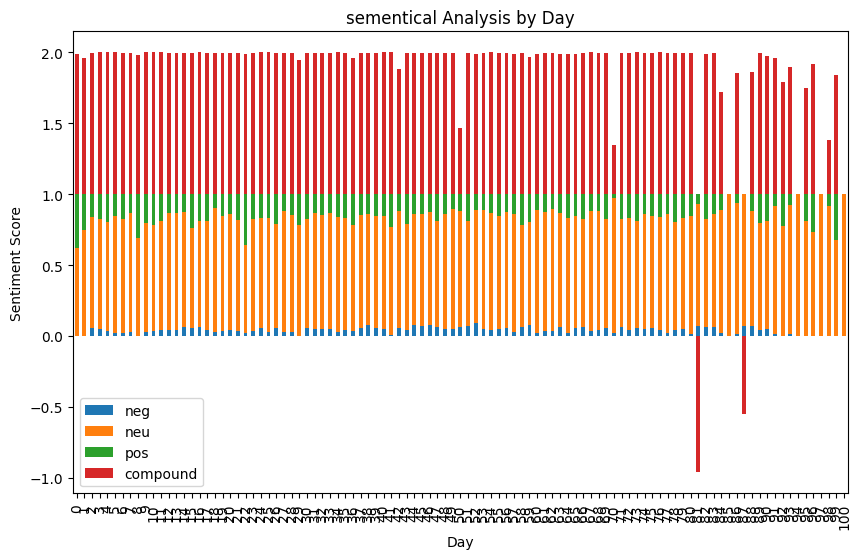

In [77]:
sementical_result.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('sementical Analysis by Day')
plt.xlabel('Day')
plt.ylabel('Sentiment Score')
plt.show()